In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

In [3]:
# Cargar el dataset
df = pd.read_csv(r"C:\2025\SIS420\Primer_parcialsis420\connect-4.data", header=None)

# Mostrar información básica
print("Filas, columnas:", df.shape)  # Debería ser (67557, 43)
print("\nPrimeras filas:")
print(df.head())

Filas, columnas: (67557, 43)

Primeras filas:
  0  1  2  3  4  5  6  7  8  9   ... 33 34 35 36 37 38 39 40 41   42
0  b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  win
1  b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  win
2  b  b  b  b  b  b  o  b  b  b  ...  b  b  b  b  b  b  b  b  b  win
3  b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  win
4  o  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  win

[5 rows x 43 columns]


In [5]:
# Codificar etiquetas (y)
le = LabelEncoder()
y = le.fit_transform(df.iloc[:, -1])  # win=0, loss=1, draw=2

# Codificar características (X) con one-hot encoding
X = pd.get_dummies(df.iloc[:, :-1], prefix_sep='_')

In [6]:
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Clases:", le.classes_)
print("Forma de X:", X.shape)

Clases: ['draw' 'loss' 'win']
Forma de X: (67557, 126)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Definir y entrenar
clf = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)
clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42)

Regresión Logística (OvR) - Train Accuracy: 0.7581
Regresión Logística (OvR) - Test Accuracy: 0.7580
Reporte de clasificación (Test):
              precision    recall  f1-score   support

        draw       0.60      0.01      0.01      1295
        loss       0.66      0.63      0.65      3341
         win       0.79      0.92      0.85      8876

    accuracy                           0.76     13512
   macro avg       0.68      0.52      0.50     13512
weighted avg       0.74      0.76      0.72     13512



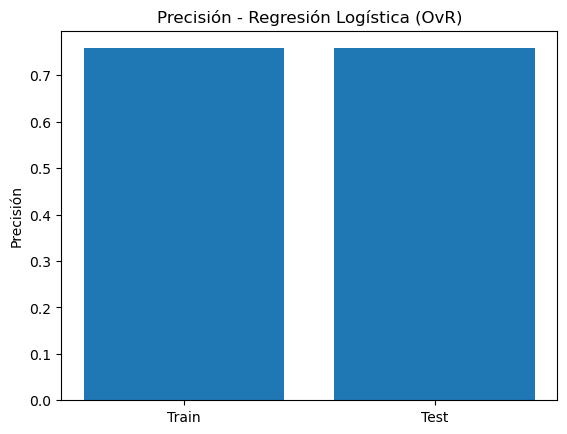

In [10]:
# Evaluar
y_pred_train = clf.predict(X_train_scaled)
y_pred_test = clf.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Regresión Logística (OvR) - Train Accuracy: {train_acc:.4f}")
print(f"Regresión Logística (OvR) - Test Accuracy: {test_acc:.4f}")
print("Reporte de clasificación (Test):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

# Gráfica de precisión (entrenamiento vs prueba)
plt.bar(["Train", "Test"], [train_acc, test_acc])
plt.ylabel("Precisión")
plt.title("Precisión - Regresión Logística (OvR)")
plt.show()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [12]:
# Convertir a tensores
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)  # Para clasificación multiclase
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

# DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [13]:
# Definir MLP para clasificación
class MLPClassification(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)  # 3 clases
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Sin softmax (CrossEntropyLoss lo incluye)
        return x

# Inicializar modelo
model = MLPClassification(X_train_scaled.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 10/50, Loss: 0.3945
Epoch 20/50, Loss: 0.3432
Epoch 30/50, Loss: 0.1820
Epoch 40/50, Loss: 0.4235
Epoch 50/50, Loss: 0.3206


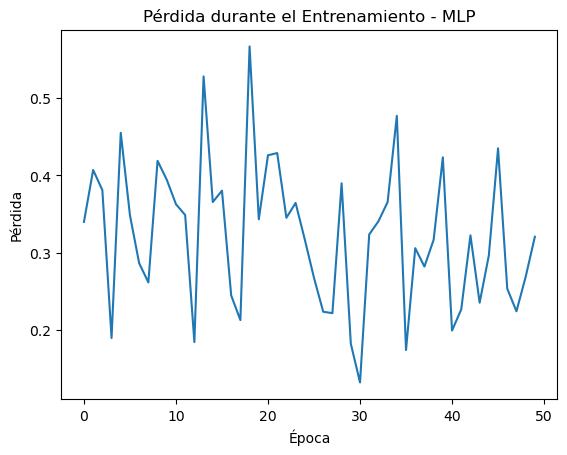

In [14]:
# Entrenamiento
epochs = 50
losses = []
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Gráfica de pérdida
plt.plot(range(epochs), losses)
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida durante el Entrenamiento - MLP")
plt.show()

MLP - Train Accuracy: 0.9074
MLP - Test Accuracy: 0.8412


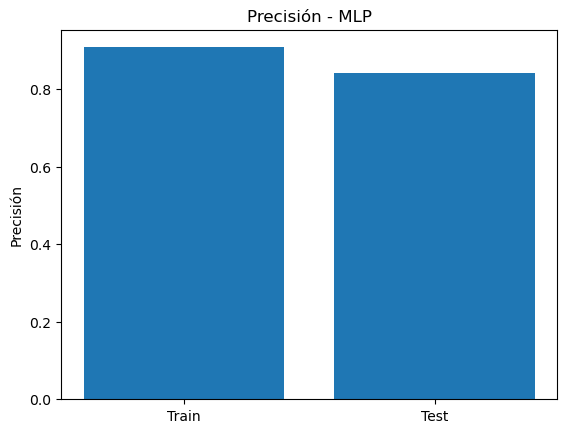

In [15]:
# Evaluación
with torch.no_grad():
    model.eval()
    train_outputs = model(X_train_tensor)
    _, y_pred_train_tensor = torch.max(train_outputs, 1)
    test_outputs = model(X_test_tensor)
    _, y_pred_test_tensor = torch.max(test_outputs, 1)
    
    train_acc_mlp = accuracy_score(y_train, y_pred_train_tensor.numpy())
    test_acc_mlp = accuracy_score(y_test, y_pred_test_tensor.numpy())
    print(f"MLP - Train Accuracy: {train_acc_mlp:.4f}")
    print(f"MLP - Test Accuracy: {test_acc_mlp:.4f}")

# Gráfica de precisión
plt.bar(["Train", "Test"], [train_acc_mlp, test_acc_mlp])
plt.ylabel("Precisión")
plt.title("Precisión - MLP")
plt.show()

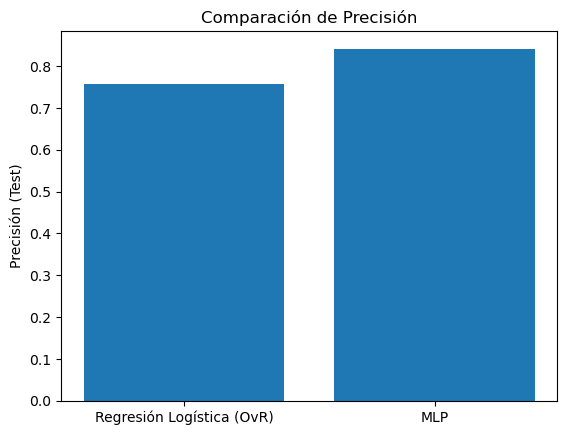


| **Aspecto**       | **Regresión Logística (OvR)** | **MLP (PyTorch)**       |
|-------------------|-------------------------------|-------------------------|
| **Precisión (Test)** | 0.7580             | 0.8412     |
| **Tiempo**        | Rápido                       | Más lento (epochs)     |
| **Ventaja**       | Simple, interpretable        | Captura no linealidades|
| **Desventaja**    | Menos flexible               | Requiere tuning        |



In [16]:
# Gráfica de precisión (test)
accuracies = [test_acc, test_acc_mlp]
model_names = ["Regresión Logística (OvR)", "MLP"]
plt.bar(model_names, accuracies)
plt.ylabel("Precisión (Test)")
plt.title("Comparación de Precisión")
plt.show()

# Tabla en Markdown
print(f"""
| **Aspecto**       | **Regresión Logística (OvR)** | **MLP (PyTorch)**       |
|-------------------|-------------------------------|-------------------------|
| **Precisión (Test)** | {test_acc:.4f}             | {test_acc_mlp:.4f}     |
| **Tiempo**        | Rápido                       | Más lento (epochs)     |
| **Ventaja**       | Simple, interpretable        | Captura no linealidades|
| **Desventaja**    | Menos flexible               | Requiere tuning        |
""")